# Customize Model and methods in NN using TensorFlow lower level API

## Whats  new? 
- How to add: 
    - Custom Loss function
    - Custom Activation function
    - Custon Initializers
    - Custom Regulizers
    - Custom Constraints
    - Custom Metrics
    - Custom Layers
    - Custom Model iteslf
    - Custom training loops
- How to save and load all the custom configs above.
- There is also a section on computing gradients using autodiff
### Reference 
- Based on Chapter 11 of  “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.”  

## Custom Loss Function

See the example below to see how to add a huber_fn as a loss function.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

#defining the huber_fn with a custom threshold, see the book for a simpler case
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        #Note that tf.where gives the value from squared_loss when is_small_error is true
        #otherwise give values from linear_loss
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

#Creating a dummy sequential model for training 
dummy_model = keras.models.Sequential([keras.layers.Dense(2),
                                      keras.layers.Dense(4),
                                      keras.layers.Dense(1)])
#dummy inputs and output
X_train = np.arange(20).reshape((10,2))
y_train = 2*np.ones(10)
#compiling model with loss function = huber_fun with threshold 1.5
dummy_model.compile(loss=create_huber(1.5), optimizer="nadam")


In [2]:
#Training the model just for demonstration
dummy_model.fit(X_train,y_train)

1/1 [==============================] - 0s 2ms/step - loss: 1.4650


### Saving and loading the model 

In [3]:
import os
os.makedirs('./saved_models',exist_ok=True)
keras.models.save_model(dummy_model,'./saved_models/hub_fun_loss_model.h5')

Note that if save the model like this , the threshold will not be saved. This means that you will have to specify the threshold value when loading the model like:


In [4]:
loaded_model_without_thresh = keras.models.load_model('./saved_models/hub_fun_loss_model.h5',
                                                     custom_objects={"huber_fn":create_huber(2.0)})
# note that the name to use is "huber_fn", which is the name of the function you gave Keras, not the name of the function that created it

__How to save custom model with custom loss function so all hyperparameters like the threshold are saved along with the model?__

This can be solved by using inheritence: creating a subclass of keras.losses.loss   class and then implementing its get_confid() method

In [5]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

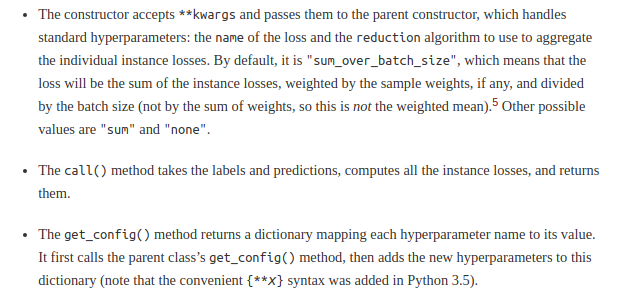

In [6]:
#Now we can use an instance of this subclass when compiling the model
dummy_model.compile(loss=HuberLoss(1.5),optimizer="nadam")

__Saving and loading the model now keeps the hyper parameter threshold.
This is because whenever we pass a class to loss function, keras expects some class methods for it like get_config(),call() etc. So if we subclass the keras.losses.Loss class, we would inherit these methods and we just need to add one more attribute to this class to take care of our new hyperparameter__

In [7]:
#Now saving and loading the model

In [8]:
os.makedirs('./saved_models',exist_ok=True)
#Saving the model 
keras.models.save_model(dummy_model,'./saved_models/custom_loss_proper.h5')

#loading the model 
saved_model = keras.models.load_model('./saved_models/custom_loss_proper.h5',
                                     custom_objects={"HuberLoss":HuberLoss})

When you save a model, Keras calls the loss instance’s get_config() method and saves the config as JSON in the HDF5 file. When you load the model, it calls the from_config() class method on the HuberLoss class: this method is implemented by the base class (Loss) and creates an instance of the class, passing **config to the constructor.

## Custom Activation functions, initializers, Regulizers and Constraints

- Implementing these custom configs is very similar to the case of custom loss function.
- If we dont want to save a hyperparameter, we could accomplish it simply as follows:

#### Defining the custom config as regular python function

In [9]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

#### Using the above custom config in a Keras layer

In [10]:
custom_layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

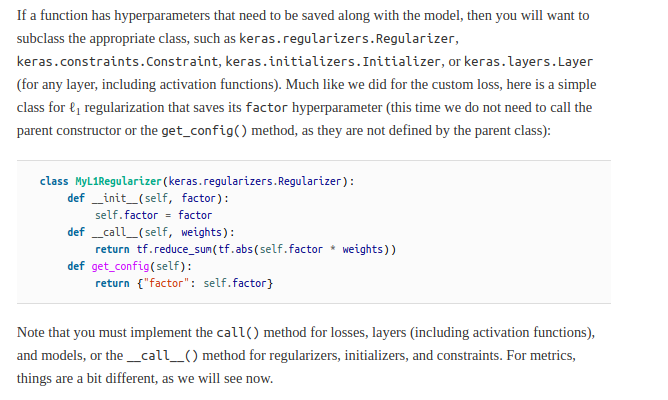

## Custom Metrics

- Metrics like accuracy, precision etc( like ratio of true positive/predicted positives) etc is useful for a human to interpret the training error, rather than looking at the loss value itseld.
- Please look at the section on custom metrics in the referenced chapter of the book.

## Custom layers

### Common uses:
- Create a layer which is not given in the default keras implementation.
- Create a layer containing multiple layers as one layer and use this new layer whenever we want a bunch of layers.

### Layers without weight
- Example is the flattening layer.
- Layer which applies an activation function. 
- Layer which applies any specific function to all the inputs.
- To accomplish this, we write a function and wrap it inside a lambda layer. More specifically we wrap it inside keras.layers.Lambda as follows:  

In [11]:
#defining an exponential function layer(applies exponential to all the inputs)
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

#Now this layer above can be used in creating keras models(sequential, functional, sublcass) like if
#it is an inbuilt layer like Flatten or Dense

__Note for advanced users working in Num PDE__ :  Such a layer will be useful in PINNs (Physics Informed Neural Networks) where we  can define the pde constrain as a layer to the output of the NN representing the solution function. For this, we put the tf.gradients(solution_u,input_layer) inside the lambda function. Note that solution_u is the final ouput of the NN representing the neural network. 

- To create a __layer with weights__ , you need to create a subclass of keras.layers.Layer class. Please see the following example.

In [12]:
class MyCustomDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

__Note that this will be useful in the parameter estimation part of PINNs__

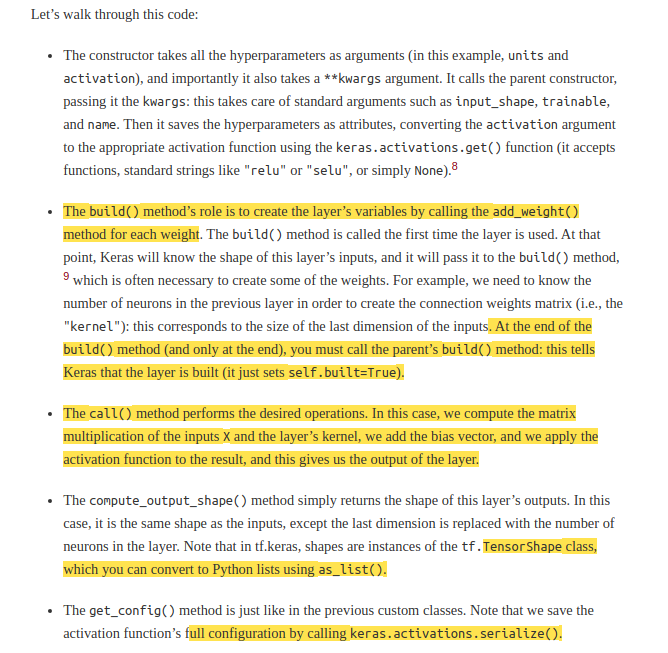

- Multiple input and outputs to the layer


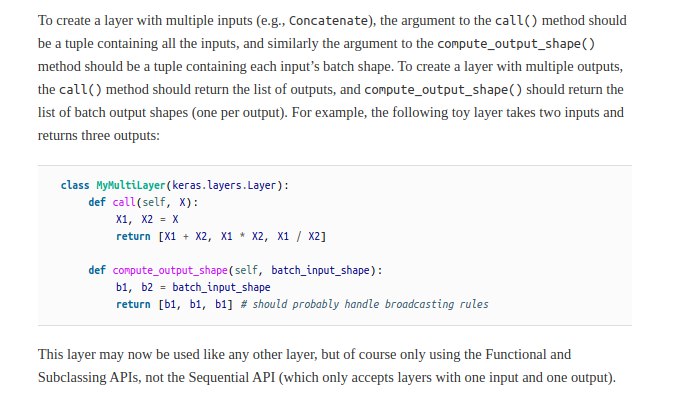

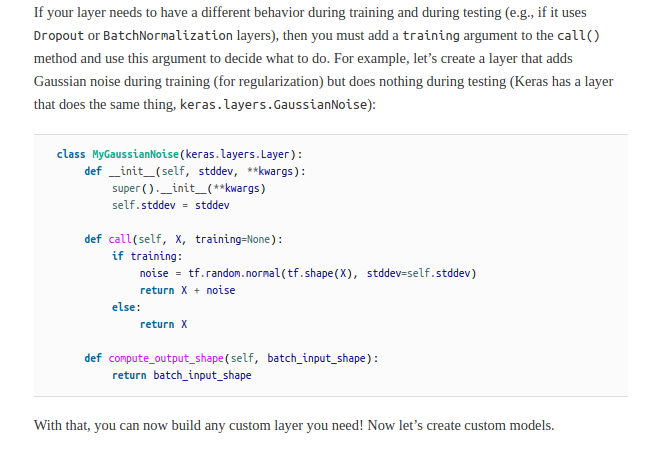

## Customs models

We try to implement the following model with two residual blocks in between ints dense layers.
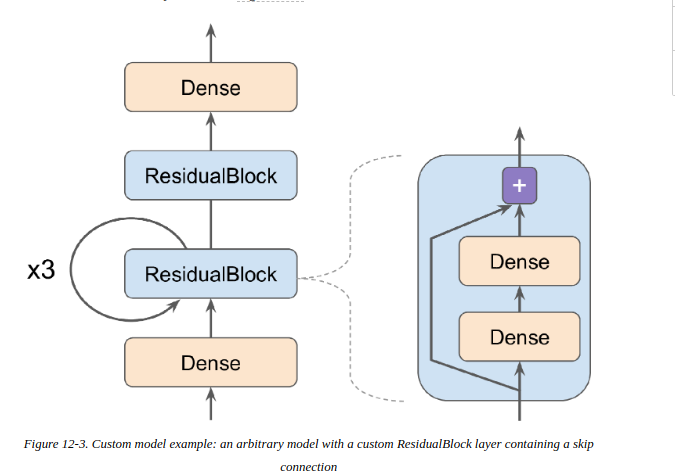

#### Defining the residual blocks as subclass of keras.laysers.Layer
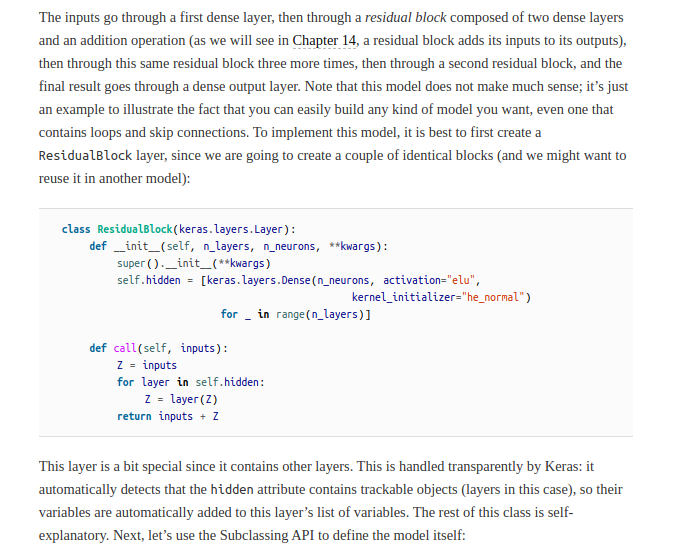

#### Defining the custom model using the residual blocks

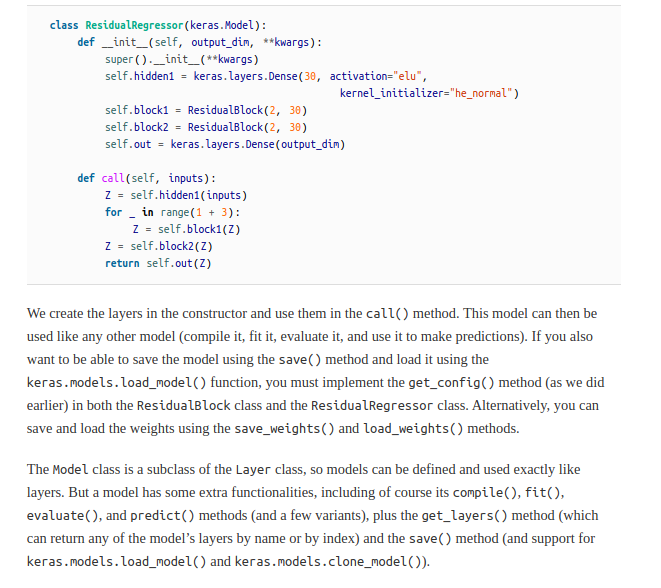

## Custom Loss and metric functions based on custom model internals

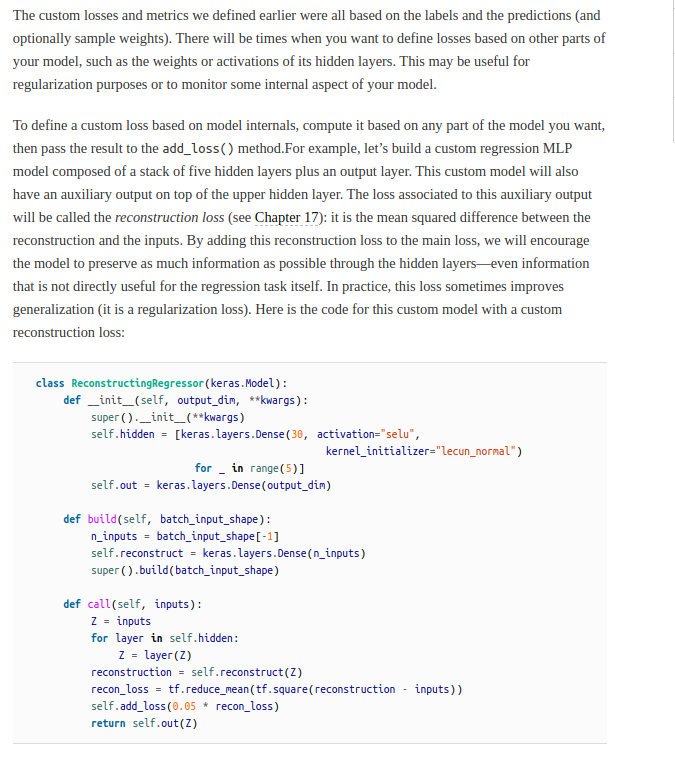

## Custom training loop

This topic is a bit more advanced and often not needed, please refer to the book to see how it is done.